<h2>A Data Driven Approach to Predicting Chemical Reaction Kinetics: Machine Learning</h2>
<br>
Maneet Goyal<sup>1</sup>, Keren Zhang<sup>2</sup>
<br>
<i><sup>1</sup>School of Civil and Environmental Engineering, <sup>2</sup>School of Chemical and Biomolecular Engineering, Georgia Institute of Technology, Atlanta, GA</i>
<hr>

In [1]:
# Displaying the report
from IPython.display import IFrame
IFrame("Report/Report.pdf", width=1000, height=500)

In [2]:
# Importing Libs/Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import itertools
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
# Reading data for reaction order classification experiments
# This notebook doesn't perform regression studies for acttivation energy prediction; refer to our report for more details on it.
reac_df = pd.read_excel("MLDataDump/TrainingDataNewSpecies.xlsx", header=0, index_col=0)
print('----- No. of Data points (rows) imported: {} -----'.format(len(reac_df.index)))

----- No. of Data points (rows) imported: 1979 -----


In [4]:
# Filtering subset of the dataframe which has reaction order reported
subset_reac_df = reac_df.query('ReactionOrder >= 0')
print('----- No. of Data points (rows) available for experiments: {} -----'.format(len(subset_reac_df.index)))
subset_reac_df.head(5)

----- No. of Data points (rows) available for experiments: 1962 -----


,Reaction Link,Records,Reactants,Products,Reactants_List,Products_List,Reactants_SIDs_List,Products_SIDs_List,Products_Available,Status_50,Status_75,Status_100,ReactionOrder,ActivationEnergy,ReactantCID,ProductCID,FeatureVector
RID,,,,,,,,,,,,,,,,,
776,http://kinetics.nist.gov/kinetics/ReactionSear...,2,Â·CH2 + Â·CH2,C2H2 + HÂ· + HÂ·,"['·CH2', '·CH2']","['C2H2', 'H·', 'H·']","[10972, 10972]","[3537, 8457, 8457]",True,True,True,True,2.0,46000.0,"[123164, 123164]","[6326, 5362549, 5362549]",[ 0. 0. 0. -1. 0. 0. 0. 0. 0. 0. 0. ...
777,http://kinetics.nist.gov/kinetics/ReactionSear...,3,Â·CH2 + Â·CH2,C2H2 + H2,"['·CH2', '·CH2']","['C2H2', 'H2']","[10972, 10972]","[3537, 7937]",True,True,True,True,2.0,50000.0,"[123164, 123164]","[6326, 783]",[-1. 0. 0. -1. 0. 0. 0. 0. 0. 0. 0. ...
780,http://kinetics.nist.gov/kinetics/ReactionSear...,2,Â·CH2,Â·CH + HÂ·,['·CH2'],"['·CH', 'H·']",[10972],"[10960, 8457]",True,True,True,True,2.0,361500.0,[123164],"[-1, 5362549]",[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
781,http://kinetics.nist.gov/kinetics/ReactionSear...,2,Â·CH2,H2 + C,['·CH2'],"['H2', 'C']",[10972],"[7937, 3419]",True,True,True,True,2.0,257500.0,[123164],"[783, 5462310]",[-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
1594,http://kinetics.nist.gov/kinetics/ReactionSear...,1,Â·Cl + Â·CH2,Â·CH + HCl,"['·Cl', '·CH2']","['·CH', 'HCl']","[11174, 10972]","[10960, 8171]",True,True,True,True,2.0,106000.0,"[5360523, 123164]","[-1, 313]",[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...


In [5]:
# Filtering just the columns we need
subset_for_exp = subset_reac_df[['FeatureVector', 'ReactionOrder']]
subset_for_exp.head(5)

,FeatureVector,ReactionOrder
RID,,
776,[ 0. 0. 0. -1. 0. 0. 0. 0. 0. 0. 0. ...,2.0
777,[-1. 0. 0. -1. 0. 0. 0. 0. 0. 0. 0. ...,2.0
780,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,2.0
781,[-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,2.0
1594,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,2.0


In [6]:
# Exploring Class Balance/Distribution and Creating X (featurevector) and y (labels)
X_vec = []
y_labl = []
X_Axis = [0, 1, 2, 3]
Y_Axis = [0]*len(X_Axis)
for rid, rxn in subset_for_exp.iterrows():
        Y_Axis[int(rxn['ReactionOrder'])] = Y_Axis[int(rxn['ReactionOrder'])] + 1
        # Feature vectors got converted to string during our routine; converting them back to Numpy arrays
        row_feat_vec = np.array(rxn['FeatureVector'].strip(' []').replace("\n", "").replace(".", "").split(), dtype=float)
        X_vec.append(row_feat_vec)
        y_labl.append(int(rxn['ReactionOrder']))


In [7]:
# Performing Oversampling
X_ror_vec, y_ror_labl = RandomOverSampler().fit_sample(X_vec, y_labl)
X_smote_vec, y_smote_labl = SMOTE(kind='svm').fit_sample(X_vec, y_labl)
axis_ror = (sorted(Counter(y_ror_labl).items()))
axis_smote = (sorted(Counter(y_smote_labl).items()))

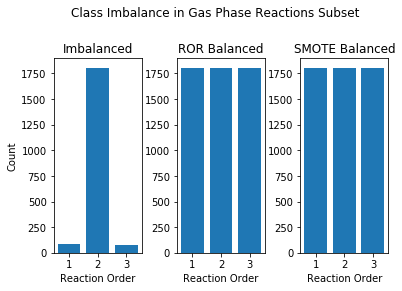

In [8]:
# Plotting Old and New Class Distributions

# Gloabal
fig, ax = plt.subplots()

# Sub1
plt.subplot(131)
plt.bar(X_Axis[1:], Y_Axis[1:])
plt.xlabel('Reaction Order')
plt.ylabel('Count')
plt.title("Imbalanced")

# Sub2
plt.subplot(132)
plt.bar(X_Axis[1:], [ele[1] for ele in axis_ror])
plt.xlabel('Reaction Order')
plt.title("ROR Balanced")

# Sub3
plt.subplot(133)
plt.bar(X_Axis[1:], [ele[1] for ele in axis_smote])
plt.xlabel('Reaction Order')
plt.title("SMOTE Balanced")

# Global
ax.set_yscale('log')
plt.suptitle('Class Imbalance in Gas Phase Reactions Subset')
plt.subplots_adjust(wspace=0.4, top=0.8)
plt.savefig('MLResultFigures/ReactionClasses.png')
plt.show()

In [9]:
# Performing Dimensionality Reduction since we have a 42 dimensions

# Initializing
pca_imbalanced = PCA(svd_solver='full')
pca_ror = PCA(svd_solver='full')
pca_smote = PCA(svd_solver='full')

# Fitting
pca_imbalanced.fit(X_vec)
pca_ror.fit(X_ror_vec)
pca_smote.fit(X_smote_vec)

# Scree Plots Data
scree_imbalanced = pca_imbalanced.explained_variance_ratio_.cumsum()
scree_ror = pca_ror.explained_variance_ratio_.cumsum()
scree_smote = pca_smote.explained_variance_ratio_.cumsum()

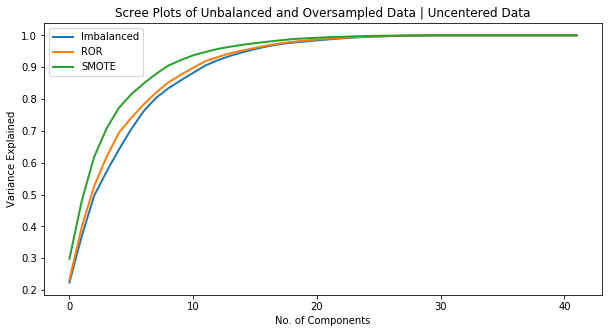

In [10]:
# Plotting Old and Oversampled data's scree plot | Uncentered data

# Gloabal
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(scree_imbalanced, linewidth=2.0, label="Imbalanced")
plt.plot(scree_ror, linewidth=2.0, label="ROR")
plt.plot(scree_smote, linewidth=2.0, label="SMOTE")
plt.xlabel('No. of Components')
plt.ylabel('Variance Explained')
plt.title("Imbalanced")
plt.legend()

plt.title('Scree Plots of Unbalanced and Oversampled Data | Uncentered Data')
plt.savefig('MLResultFigures/ScreePlotsUncentered.png')
plt.show()

The trend in the scree plots is expected as appending rows to a data matrix is expected to either increase the singular values or keep them same as before. This can be proved at least for the largest and the smallest singular values (Refer GVL4 Problem 2.4.9). Hence, the variance explained by the principal components of a matrix  are expected to either increase or remain the same when we compare imbalanced and oversampled data. Note that the `variance explained` or the `eigen values of the covariance matrix` are just the square of the singular values of the centered data matrix.
<hr>
The above discussion reminds us of an important part of PCA, i.e. `CENTERING` (via mean-averaging). IMHO, it is so important that it is perhaps one of the reasons that earned PCA a distinct name; without centering, it might have been referred to as just the `Eigen Value Decomposition` of symmetric matrices. You may have already noticed that centering was not performed over our data, so we have not yet done any PCA. 

In [11]:
# Standarding (centering + scaling) data matrix

# Initializing
centered_unbalanced = StandardScaler()
centered_ror = StandardScaler()
centered_smote = StandardScaler()

# Standardizing
X_vec_std = centered_unbalanced.fit_transform(X_vec)
X_ror_vec_std = centered_unbalanced.fit_transform(X_ror_vec)
X_smote_vec_std = centered_unbalanced.fit_transform(X_smote_vec)

In [12]:
# Performing Dimensionality Reduction since we have a 42 dimensions

# Initializing
pca_imbalanced_std = PCA(svd_solver='full')
pca_ror_std = PCA(svd_solver='full')
pca_smote_std = PCA(svd_solver='full')

# Fitting
pca_imbalanced_std.fit(X_vec_std)
pca_ror_std.fit(X_ror_vec_std)
pca_smote_std.fit(X_smote_vec_std)

# Scree Plots Data
scree_imbalanced_std = pca_imbalanced_std.explained_variance_ratio_.cumsum()
scree_ror_std = pca_ror_std.explained_variance_ratio_.cumsum()
scree_smote_std = pca_smote_std.explained_variance_ratio_.cumsum()

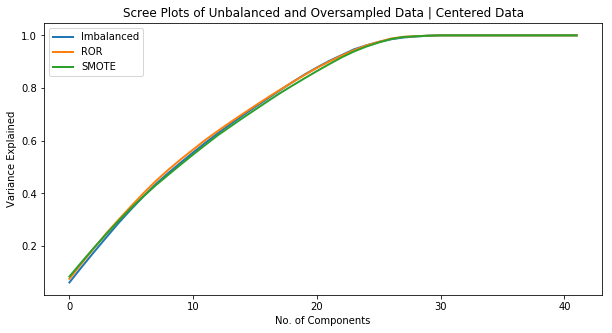

In [13]:
# Plotting Old and Oversampled data's scree plot | Centered data

# Global
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(scree_imbalanced_std, linewidth=2.0, label="Imbalanced")
plt.plot(scree_ror_std, linewidth=2.0, label="ROR")
plt.plot(scree_smote_std, linewidth=2.0, label="SMOTE")
plt.xlabel('No. of Components')
plt.ylabel('Variance Explained')
plt.title("Imbalanced")
plt.legend()

plt.title('Scree Plots of Unbalanced and Oversampled Data | Centered Data')
plt.savefig('MLResultFigures/ScreePlotsCentered.png')
plt.show()

In [14]:
#Classification via Random Forests (RF)

# Initializing
clf_unbalanced = RandomForestClassifier(criterion="entropy")
clf_ror = RandomForestClassifier(criterion="entropy")
clf_smote = RandomForestClassifier(criterion="entropy")

# Training and Cross validating
scores_unbalanced = np.mean(cross_val_score(clf_unbalanced, X_vec_std, y_labl, cv=10))
scores_ror = np.mean(cross_val_score(clf_ror, X_ror_vec_std, y_ror_labl, cv=10))
scores_smote = np.mean(cross_val_score(clf_smote, X_smote_vec_std, y_smote_labl, cv=10))

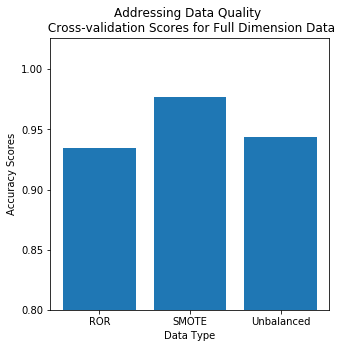

In [15]:
# Plotting Cross validation scores

# Global
fig, ax = plt.subplots(figsize=(5,5))
plt.bar(['Unbalanced', 'ROR', 'SMOTE'], [scores_unbalanced, scores_ror, scores_smote])
plt.xlabel('Data Type')
plt.ylabel('Accuracy Scores')
plt.title('Addressing Data Quality \n Cross-validation Scores for Full Dimension Data')
ax.set_ylim(ymin=0.8)
plt.savefig('MLResultFigures/CVScoreFull.png')
plt.show()

Two observations are worth discussing about: <span style="color:gray">model trained over imbalanced data is performing better than that trained over ROR oversampled data</span>; and <span style="color:gray">model trained over SMOTE data is performing better than the other 2 models</span>.
<hr>
Observation 1 is expected because due to disproportionate class distribution in the `Unbalanced` data, the model might be getting trained and tested over similar datasets, comprising majority of the $2^{nd}$ order data points/reactions. Observation 2 is more interesing; due to the `interpolation` component of the SMOTE algorithm, we might be getting a good representation of the minority classes and consequently, we might be obtaing a more robust random forest in each k-fold CV interation. 

In [16]:
# Perfoming k-Fold cross validation of Data with Reduced Dimension

# Initializing PCA models
pca_imbalanced_27 = PCA(n_components=27, svd_solver='full')
pca_ror_27 = PCA(n_components=27, svd_solver='full')
pca_smote_27 = PCA(n_components=27, svd_solver='full')

# Getting tranformed data
X_vec_std_27 = pca_imbalanced_27.fit_transform(X_vec_std)
X_ror_vec_std_27 = pca_ror_27.fit_transform(X_ror_vec_std)
X_smote_vec_std_27 = pca_smote_27.fit_transform(X_smote_vec_std)

<hr>
`27 out of 42` principal components are chosen because they explain more than `99%` variance.
<hr>

In [17]:
#Classification via Random Forests (RF) | Reduced Dimension data

# Initializing
clf_unbalanced_27 = RandomForestClassifier(criterion="entropy")
clf_ror_27 = RandomForestClassifier(criterion="entropy")
clf_smote_27 = RandomForestClassifier(criterion="entropy")

# Training and Cross validating
scores_unbalanced_27 = np.mean(cross_val_score(clf_unbalanced_27, X_vec_std_27, y_labl, cv=10))
scores_ror_27 = np.mean(cross_val_score(clf_ror_27, X_ror_vec_std_27, y_ror_labl, cv=10))
scores_smote_27 = np.mean(cross_val_score(clf_smote_27, X_smote_vec_std_27, y_smote_labl, cv=10))

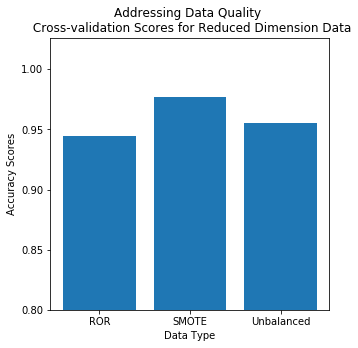

In [18]:
# Plotting Cross validation scores | Reduced Dimension data

# Global
fig, ax = plt.subplots(figsize=(5,5))
plt.bar(['Unbalanced', 'ROR', 'SMOTE'], [scores_unbalanced_27, scores_ror_27, scores_smote_27])
plt.xlabel('Data Type')
plt.ylabel('Accuracy Scores')
plt.title('Addressing Data Quality \n Cross-validation Scores for Reduced Dimension Data')
ax.set_ylim(ymin=0.8)
plt.savefig('MLResultFigures/CVScoreReduced.png')
plt.show()

The above results are similar to what were obtained for the full dimensional data. Now we plot the covariance matrices of the reducted dimension data to look for covariance between individual dimensions.

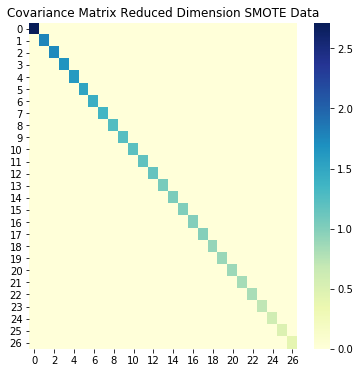

In [19]:
# Plotting Covariance Matrices
fig, ax = plt.subplots(figsize=(6,6))
seaborn.heatmap(np.cov(X_smote_vec_std_27.T), cmap="YlGnBu", ax=ax)
plt.title('Covariance Matrix Reduced Dimension SMOTE Data')
plt.savefig('MLResultFigures/CovMat.png')
plt.show()

The covariance matrix suggests that the standardized and reduced data matrix, `X_smote_vec_std_27.T`,  was orthogonal which is quite probably since we are dealing with sparse matrices. Further, typically, the presence of 1 type of chemical bond (say, C-H) is independent to the presence of another type of bond (say, C=O).

In [25]:
# Since, SMOTE trained Random Forest performed the best, we now attempt to optmize it's hyper parameters to try and come up
# more accurate model.
param_grid = [{'criterion': ['gini', 'entropy']}]
clf = GridSearchCV(clf_smote_27, param_grid, cv=10)
clf.fit(X_smote_vec_std_27, y_smote_labl)
clf.best_params_

{'criterion': 'gini'}

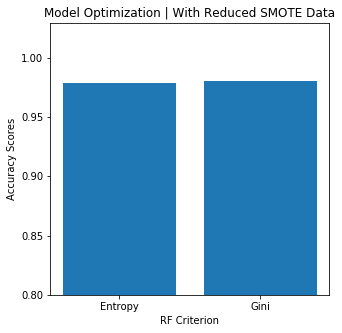

In [26]:
# Here is the best criterion
fig, ax = plt.subplots(figsize=(5,5))
plt.bar(['Gini', 'Entropy'], clf.cv_results_['mean_test_score'])
plt.xlabel('RF Criterion')
plt.ylabel('Accuracy Scores')
plt.title('Model Optimization | With Reduced SMOTE Data')
ax.set_ylim(ymin=0.8)
plt.savefig('MLResultFigures/RFOptimize.png')
plt.show()

In [ ]:
# Finally, we perform complexity optmization to figure out the optmium number of tree and tree depth
# We are using grid_search for complexity optimiztion
param_grid_2 = [{'n_estimators': list(range(1,100,10)),
                'max_depth': list(range(1,100,10)),
                'criterion': ['gini']}]  # gini chosen because it was found to be better hyperparameter
clf = GridSearchCV(clf_smote_27, param_grid_2, cv=10)
clf.fit(X_smote_vec_std_27, y_smote_labl)

In [ ]:
# Plotting Score vs Complexity (No of Trees, Tree Depth) Plot
x_val_opti_study = clf.cv_results_['params']
y_val_opti_study = clf.cv_results_['mean_test_score']
fig, ax = plt.subplots(figsize=(10,5))
for i in range(10):
    plt.plot([ele['n_estimators'] for ele in x_val_opti_study[10*i:10*(i+1)]] , y_val_opti_study[10*i:10*(i+1)], 
             label=x_val_opti_study[10*i]['max_depth'])
ax.set_xlabel('No. of Trees')
ax.set_ylabel('10-Fold CV Score')
plt.legend()
plt.title("Optimizing Model Compelxity")
plt.savefig('MLResultFigures/ComplexityOptimize.png')
plt.show()

<hr>
For optimization, we chose to first minimize the number of tree and then the tree depth. We propose `11 trees with max_depth of 11` as the optmium complexity random forest.
<hr>

In [ ]:
# Now, we set up a final RF model and split our data into test and train data for the final model evaluation
clf_smote_27_std_opt = RandomForestClassifier(criterion="gini", n_estimators=11, max_depth=11)
X_train, X_test, y_train, y_test = train_test_split(X_smote_vec_std_27, y_smote_labl, test_size=0.33, random_state=42)

In [ ]:
# Training the model with optimal parameters
clf_smote_27_std_opt.fit(X_train, y_train)
y_pred = clf_smote_27_std_opt.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
# This function is adopted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Finally, here's the confusion matrix with optmium complexity model
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3], title='Confusion matrix \n SMOTE | Reduced, Stanadrdized Data')
plt.savefig('ConfusionMatrix.png')
plt.show()

As seen from the figure above, we got a great accuracy of `33:67` Test:Train Split. This marks the end of our classification study. We got great results with Random Forest model and looking at the results, dimensionality reduction didn't hurt the accuracy much.